In [31]:
import matplotlib.pyplot as plt
from skimage.transform import swirl
import numpy as np
from PIL import Image, ImageFilter, ImageDraw
import torch
import torchvision.transforms as transforms
import os
import cv2

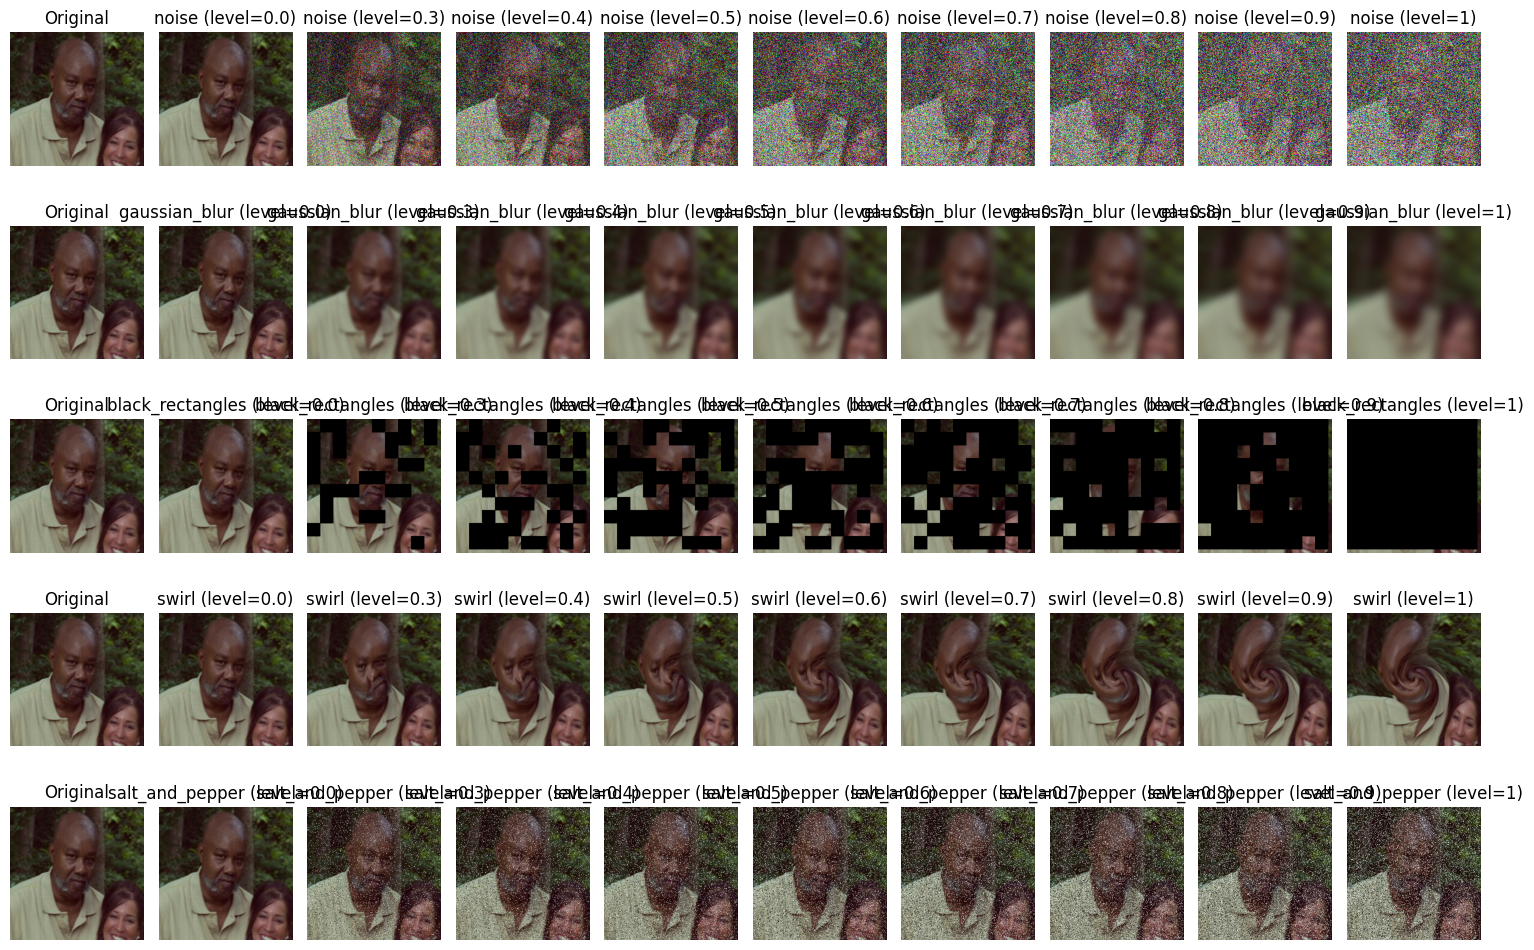

In [55]:
import cv2
import numpy as np

def add_noise(image, noise_level, noise_type='random'):
    import torch

    if noise_level == 0.0:
        return image

    if noise_type == 'noise':
        noisy_image = image + noise_level * torch.randn_like(image)
        noisy_image = torch.clip(noisy_image, 0.0, 1.0)
    elif noise_type == 'gaussian_blur':
        noisy_image = image + noise_level * torch.randn_like(image)
        noisy_image = apply_gaussian_blur(image, noise_level)
    elif noise_type == 'black_rectangles':
        noisy_image = image + noise_level * torch.randn_like(image)
        noisy_image = apply_black_rectangles(image, noise_level)
    elif noise_type == 'swirl':
        noisy_image = image + noise_level * torch.randn_like(image)
        noisy_image = apply_swirl(image, noise_level)
    elif noise_type == 'salt_and_pepper':
        noisy_image = image + noise_level * torch.randn_like(image)
        noisy_image = apply_salt_and_pepper(image, noise_level)
    else:
        raise ValueError(f"Unexpected noise_type value: {noise_type}")

    return noisy_image

def apply_salt_and_pepper(image, noise_level):
    pil_image = transforms.ToPILImage()(image).convert("RGB")
    image_np = np.array(pil_image)
    
    # Add salt and pepper noise
    row, col, ch = image_np.shape
    s_vs_p = 0.5
    amount = noise_level / 10  # Increase the amount for a stronger effect
    out = np.copy(image_np)

    # Salt mode
    num_salt = np.ceil(amount * image_np.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image_np.shape]
    out[coords[0], coords[1], :] = 255

    # Pepper mode
    num_pepper = np.ceil(amount * image_np.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image_np.shape]
    out[coords[0], coords[1], :] = 0
    
    noisy_image_pil = Image.fromarray(out)
    return transforms.ToTensor()(noisy_image_pil)

def apply_swirl(image, noise_level):
    
    # Convert the tensor image to a numpy array
    pil_image = transforms.ToPILImage()(image).convert("RGB")
    image_np = np.array(pil_image)
    
    # Apply swirl distortion
    strength = noise_level * 5  # Adjust strength for more noticeable effect
    swirled_image_np = swirl(image_np, strength=strength, radius=250, rotation=0)
    # Convert back to PIL image
    swirled_image_pil = Image.fromarray((swirled_image_np * 255).astype(np.uint8))
    return transforms.ToTensor()(swirled_image_pil)

def apply_gaussian_blur(image, noise_level):
    pil_image = transforms.ToPILImage()(image).convert("RGB")
    blur_radius_mapped = noise_level * 10
    blurred_image = pil_image.filter(ImageFilter.GaussianBlur(radius=blur_radius_mapped))
    return transforms.ToTensor()(blurred_image)

def apply_black_rectangles(image, noise_level, grid_size=10):
    pil_image = transforms.ToPILImage()(image).convert("RGB")
    draw = ImageDraw.Draw(pil_image)
    width, height = pil_image.size
    cell_width = width // grid_size
    cell_height = height // grid_size
    
    total_cells = grid_size * grid_size
    cells_to_fill = int(total_cells * noise_level)
    
    cells = [(i, j) for i in range(grid_size) for j in range(grid_size)]
    np.random.shuffle(cells)
    
    for cell in cells[:cells_to_fill]:
        x1 = cell[0] * cell_width
        y1 = cell[1] * cell_height
        x2 = x1 + cell_width
        y2 = y1 + cell_height
        draw.rectangle([x1, y1, x2, y2], fill="black")
    
    return transforms.ToTensor()(pil_image)

    

def load_and_preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor()
    ])
    img = Image.open(img_path).convert("RGB")
    img = transform(img)
    return img

def plot_images_with_noise(img_path, noise_levels, noise_types):
    original_img = load_and_preprocess_image(img_path)

    fig, axes = plt.subplots(len(noise_types), len(noise_levels) + 1, figsize=(15, 10))
    if len(noise_types) == 1:
        axes = [axes]

    for i, noise_type in enumerate(noise_types):
        axes[i][0].imshow(transforms.ToPILImage()(original_img))
        axes[i][0].set_title('Original')
        axes[i][0].axis('off')

        for j, noise_level in enumerate(noise_levels):
            noisy_img = add_noise(original_img.clone(), noise_level, noise_type)
            axes[i][j + 1].imshow(transforms.ToPILImage()(noisy_img))
            axes[i][j + 1].set_title(f'{noise_type} (level={noise_level})')
            axes[i][j + 1].axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
img_path = 'D:/FID-Evaluator/fid_fake/fid_fake/real_23.jpg'  # Update with the correct path to your image
noise_levels = [0.0, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
noise_types = ['noise', 'gaussian_blur', 'black_rectangles', 'swirl', 'salt_and_pepper']
plot_images_with_noise(img_path, noise_levels, noise_types)

In [4]:
import torch

# Get the PyTorch version
pytorch_version = torch.__version__

# Get the CUDA version that PyTorch is built against
cuda_version = torch.version.cuda

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Print the results
print(f"PyTorch version: {pytorch_version}")
print(f"CUDA version: {cuda_version}")
print(f"CUDA available: {cuda_available}")

PyTorch version: 2.3.1+cu118
CUDA version: 11.8
CUDA available: True
